In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import pandas as pd
from itertools import combinations_with_replacement
sns.set()
df = pd.read_csv('TempLinkoping2016.csv')
df.head()

,time,temp
0,0.002732,0.1
1,0.005464,-4.5
2,0.008197,-6.3
3,0.010929,-9.6
4,0.013661,-9.9


In [2]:
X = df.iloc[:, 0:1].values
Y = df.iloc[:, 1:2].values

In [3]:
n_features = X.shape[1]
degree = 15
combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
flat_combs = [item for sublist in combs for item in sublist]
X_new = np.empty((X.shape[0], len(flat_combs)))
for i, index_combs in enumerate(flat_combs):
    X_new[:, i] = np.prod(X[:, index_combs], axis=1)

In [8]:
class Lasso:
    def __init__(self, learning_rate, alpha):
        self.X = tf.placeholder(tf.float32, (None, X_new.shape[1]))
        self.Y = tf.placeholder(tf.float32, (None, 1))
        w = tf.Variable(tf.random_normal([X_new.shape[1], 1]))
        b = tf.Variable(tf.random_normal([1]))
        self.logits = tf.matmul(self.X, w) + b
        l1_regularizer = tf.contrib.layers.l1_regularizer(scale=alpha, scope=None)
        weights = tf.trainable_variables()
        regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits)) + regularization_penalty
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Lasso(3, 0.0005)
sess.run(tf.global_variables_initializer())
for i in range(1000):
    cost, _ = sess.run([model.cost, model.optimizer], feed_dict={model.X:X_new, model.Y:Y})
    if (i+1) % 100 == 0:
        print('epoch %d, MSE: %f'%(i+1, cost))

epoch 100, MSE: 12.881452
epoch 200, MSE: 12.299575
epoch 300, MSE: 12.057304
epoch 400, MSE: 11.931226
epoch 500, MSE: 11.870151
epoch 600, MSE: 11.835235
epoch 700, MSE: 11.812588
epoch 800, MSE: 11.792359
epoch 900, MSE: 11.772836
epoch 1000, MSE: 11.755094


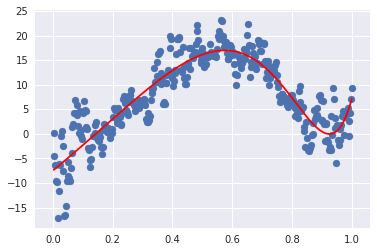

In [10]:
y_output = sess.run(model.logits, feed_dict={model.X:X_new})
plt.scatter(X[:,0],Y[:,0])
plt.plot(X,y_output, c='red')
plt.show()

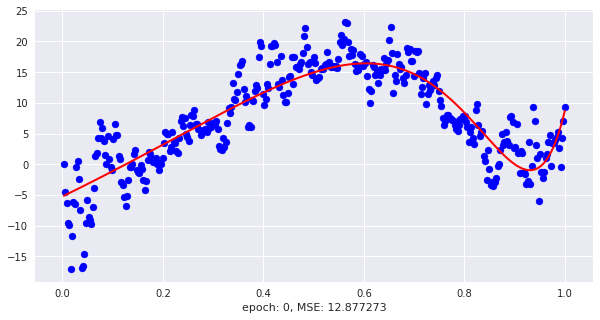

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Lasso(3, 0.0005)
sess.run(tf.global_variables_initializer())

fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.scatter(X[:,0],Y[:,0], c='b')
cost, y_output = sess.run([model.cost, model.logits], feed_dict={model.X:X_new, model.Y:Y})
ax.set_xlabel('epoch: %d, MSE: %f'%(0,cost))
line, = ax.plot(X,y_output, lw=2, c='r')

def gradient_mean_square(epoch):
    cost, y_output, _ = sess.run([model.cost, model.logits, model.optimizer], feed_dict={model.X:X_new, model.Y:Y})
    line.set_data(X,y_output)
    ax.set_xlabel('epoch: %d, MSE: %f'%(epoch,cost))
    return line, ax

anim = animation.FuncAnimation(fig, gradient_mean_square, frames=100, interval=200)
anim.save('animation-lasso-regression.gif', writer='imagemagick', fps=10)